# Train decoder

## Dataset loading

### Import libraries

In [1]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import os

os.chdir("/home/ubuntu/")

/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

Load the dataset with hugging face and split between train and test.

In [2]:
ds = load_dataset('json', data_files='/home/ubuntu/data/intestinal_organoid_dataset/one_image_metadata.json')

test_dataset = ds["train"].filter(lambda example: example["split"] == "test")
del(ds)

Define the local folder where the dataset is located.

In [3]:
# Define dataset location folder
data_folder = "/home/ubuntu/data/intestinal_organoid_dataset/"

Define the processor (encoder) of SAM.

In [4]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

Adapt the actual dataset for SAM.

In [5]:
from utils.sam_dataset import SAMDataset
sam_test_dataset = SAMDataset(dataset=test_dataset, processor=processor, data_folder=data_folder)
del(test_dataset)

In [6]:
item = sam_test_dataset[0]
print("Keys in item:", item.keys())  # Add this line to print the keys

Keys in item: dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask', 'original_image'])


### Create PyTorch dataloader

In [7]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(sam_test_dataset, batch_size=1, shuffle=True)

In [8]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)
del(k, v)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
ground_truth_mask torch.Size([1, 450, 450])
original_image torch.Size([1, 450, 450, 3])


/home/ubuntu/venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


## Train SAM

### Load the model

Make sure we only compute gradients for the mask decoder

In [9]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
del(name)

See first mask prediction.

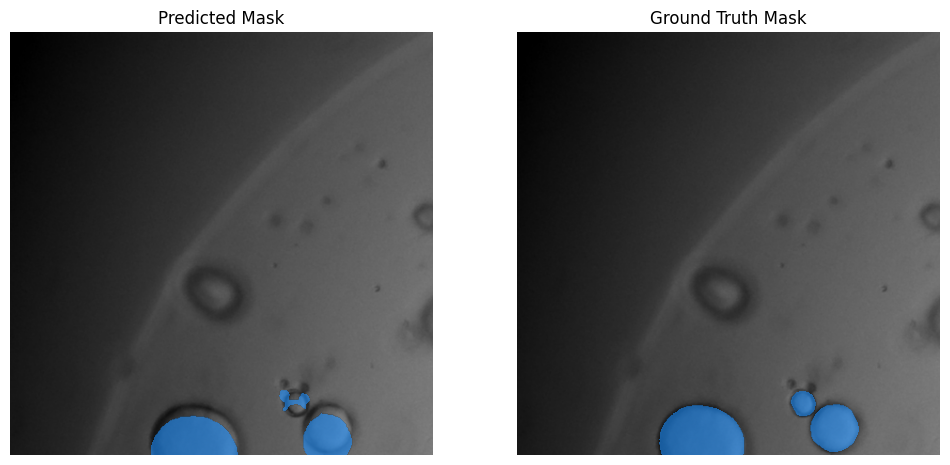

In [10]:
from utils.inference_sam import show_mask

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Predicted Mask
axes[0].imshow(np.array(batch["original_image"]).squeeze())
first_masks = []
for batch in test_dataloader:
    # Compute mask
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                    input_boxes=batch["input_boxes"].to(device),
                    multimask_output=False)
    # Post-process mask
    predicted_masks = outputs.pred_masks.to(device)
    predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                    mode="bilinear", align_corners=False)
    predicted_masks = predicted_masks[..., :992, :1024]
    predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                    mode="bilinear", align_corners=False)
    # apply sigmoid
    mask_seg_prob = torch.sigmoid(predicted_masks)
    # convert soft mask to hard mask
    mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
    first_mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
    first_masks.append(first_mask_seg)
    show_mask(first_mask_seg, axes[0])
axes[0].set_title("Predicted Mask")
axes[0].axis("off")

# Plot Ground Truth Mask
axes[1].imshow(np.array(batch["original_image"]).squeeze())
for batch in test_dataloader:
    ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
    show_mask(ground_truth_masks, axes[1])
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

plt.show()

### Train the model

In [11]:
from torch.optim import Adam
import monai
from utils.model_training import train_model


# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# Define loss
geom_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
# Define number of epochs
num_epochs = 200
train_model(model = model, optimizer = optimizer, seg_loss = geom_loss, 
            dataloader = test_dataloader, num_epochs = num_epochs, device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


EPOCH: 1
Mean loss: 0.40747882922490436


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


EPOCH: 2
Mean loss: 0.5531060894330343


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


EPOCH: 3
Mean loss: 0.337157279253006


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


EPOCH: 4
Mean loss: 0.3760717958211899


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


EPOCH: 5
Mean loss: 0.5559507409731547


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


EPOCH: 6
Mean loss: 0.27408599356810254


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 7
Mean loss: 0.3349576493104299


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 8
Mean loss: 0.49031321207682294


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 9
Mean loss: 0.5138840476671854


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


EPOCH: 10
Mean loss: 0.3983090321222941


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 11
Mean loss: 0.3207383106152217


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


EPOCH: 12
Mean loss: 0.3061576833327611


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 13
Mean loss: 0.2817862331867218


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 14
Mean loss: 0.3107237567504247


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 15
Mean loss: 0.39354590078194934


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 16
Mean loss: 0.34679219126701355


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


EPOCH: 17
Mean loss: 0.561619500319163


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 18
Mean loss: 0.4939352249105771


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 19
Mean loss: 0.2655031085014343


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 20
Mean loss: 0.41683705896139145


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 21
Mean loss: 0.2873092144727707


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 22
Mean loss: 0.24647346635659537


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 23
Mean loss: 0.2584252456823985


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 24
Mean loss: 0.26108243068059284


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 25
Mean loss: 0.2485155165195465


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


EPOCH: 26
Mean loss: 0.2540129100282987


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 27
Mean loss: 0.18584917734066644


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 28
Mean loss: 0.2584638049205144


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


EPOCH: 29
Mean loss: 0.23374234388271967


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 30
Mean loss: 0.27971797436475754


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 31
Mean loss: 0.2616574764251709


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 32
Mean loss: 0.25651749471823376


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 33
Mean loss: 0.28577350576718646


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 34
Mean loss: 0.24625281492869058


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 35
Mean loss: 0.2254011109471321


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 36
Mean loss: 0.28279930104811984


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 37
Mean loss: 0.3164239500959714


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 38
Mean loss: 0.252044640481472


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 39
Mean loss: 0.2054097130894661


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 40
Mean loss: 0.21926449363430342


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 41
Mean loss: 0.22683378805716833


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 42
Mean loss: 0.42078155527512234


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 43
Mean loss: 0.2667495335141818


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 44
Mean loss: 0.22775088250637054


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 45
Mean loss: 0.24055702487627664


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 46
Mean loss: 0.21444222331047058


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 47
Mean loss: 0.22984554866949716


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 48
Mean loss: 0.20920362571875253


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 49
Mean loss: 0.2073517714937528


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 50
Mean loss: 0.2252690071860949


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 51
Mean loss: 0.21554941684007645


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 52
Mean loss: 0.19091482336322466


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 53
Mean loss: 0.22171452641487122


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 54
Mean loss: 0.213357446094354


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 55
Mean loss: 0.239167590936025


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 56
Mean loss: 0.18342425922552744


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 57
Mean loss: 0.20820621401071548


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 58
Mean loss: 0.18882230296730995


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 59
Mean loss: 0.19574512789646784


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 60
Mean loss: 0.15112227449814478


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 61
Mean loss: 0.19831700747211775


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 62
Mean loss: 0.1860238735874494


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 63
Mean loss: 0.21912269418438277


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 64
Mean loss: 0.18872261668244997


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 65
Mean loss: 0.2106113446255525


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 66
Mean loss: 0.19919935365517935


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 67
Mean loss: 0.17084069922566414


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 68
Mean loss: 0.16858298207322756


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


EPOCH: 69
Mean loss: 0.1598407949010531


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 70
Mean loss: 0.17574845254421234


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 71
Mean loss: 0.18252859885493913


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 72
Mean loss: 0.1540683334072431


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 73
Mean loss: 0.16204013923803964


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 74
Mean loss: 0.22514957437912622


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 75
Mean loss: 0.14043855915466943


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 76
Mean loss: 0.2561673733095328


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 77
Mean loss: 0.1875323752562205


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 78
Mean loss: 0.15290650725364685


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 79
Mean loss: 0.13104561467965445


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 80
Mean loss: 0.15053962046901384


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 81
Mean loss: 0.16457509497801462


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 82
Mean loss: 0.13267851124207178


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 83
Mean loss: 0.13585403809944788


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 84
Mean loss: 0.1390004108349482


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 85
Mean loss: 0.1392715908586979


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 86
Mean loss: 0.14043955194453397


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 87
Mean loss: 0.13493347043792406


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 88
Mean loss: 0.13012205312649408


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 89
Mean loss: 0.312573179602623


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 90
Mean loss: 0.09849054242173831


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 91
Mean loss: 0.15259775271018347


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 92
Mean loss: 0.16896724328398705


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 93
Mean loss: 0.14380516856908798


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 94
Mean loss: 0.23491194595893225


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 95
Mean loss: 0.14684733313818774


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 96
Mean loss: 0.3150300197303295


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 97
Mean loss: 0.17546473567684492


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 98
Mean loss: 0.14252169181903204


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 99
Mean loss: 0.16784458855787912


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 100
Mean loss: 0.15030904114246368


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 101
Mean loss: 0.11809687564770381


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 102
Mean loss: 0.13021752859155336


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 103
Mean loss: 0.11659976281225681


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 104
Mean loss: 0.1078530674179395


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 105
Mean loss: 0.11998888850212097


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 106
Mean loss: 0.09964496393998463


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 107
Mean loss: 0.1847333957751592


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 108
Mean loss: 0.10916582991679509


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 109
Mean loss: 0.09087076038122177


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 110
Mean loss: 0.099285705635945


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 111
Mean loss: 0.1309742828210195


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 112
Mean loss: 0.08721724338829517


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 113
Mean loss: 0.10522511601448059


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 114
Mean loss: 0.10100750500957172


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 115
Mean loss: 0.1408503217001756


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 116
Mean loss: 0.0941820206741492


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 117
Mean loss: 0.0899615300198396


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 118
Mean loss: 0.11823000262180965


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 119
Mean loss: 0.11523014182845752


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 120
Mean loss: 0.0820635948330164


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 121
Mean loss: 0.07282751736541589


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 122
Mean loss: 0.0809178575873375


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 123
Mean loss: 0.08540381863713264


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 124
Mean loss: 0.08666033670306206


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 125
Mean loss: 0.09153572966655095


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 126
Mean loss: 0.08224679715931416


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 127
Mean loss: 0.10521284615000089


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 128
Mean loss: 0.07850055148204167


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 129
Mean loss: 0.07704953600962956


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 130
Mean loss: 0.0785526732603709


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 131
Mean loss: 0.07689535866181056


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 132
Mean loss: 0.08498421000937621


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 133
Mean loss: 0.06877232901751995


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 134
Mean loss: 0.06801270693540573


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 135
Mean loss: 0.06529551620284717


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 136
Mean loss: 0.07340571532646815


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 137
Mean loss: 0.06879240895311038


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 138
Mean loss: 0.06979481751720111


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 139
Mean loss: 0.05777148405710856


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 140
Mean loss: 0.06826284527778625


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 141
Mean loss: 0.06993841504057248


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 142
Mean loss: 0.06812925885121028


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 143
Mean loss: 0.06903754112621148


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 144
Mean loss: 0.06449012830853462


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 145
Mean loss: 0.07182206958532333


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 146
Mean loss: 0.06523303563396136


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 147
Mean loss: 0.05625453653434912


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 148
Mean loss: 0.0744401402771473


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 149
Mean loss: 0.07769221502045791


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 150
Mean loss: 0.05495368503034115


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 151
Mean loss: 0.06088279063502947


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 152
Mean loss: 0.06273504284520943


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 153
Mean loss: 0.05534954182803631


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 154
Mean loss: 0.1275325814882914


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 155
Mean loss: 0.05264619489510854


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 156
Mean loss: 0.059221489975849785


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 157
Mean loss: 0.08131633574763934


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 158
Mean loss: 0.06499513983726501


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 159
Mean loss: 0.06428226952751477


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 160
Mean loss: 0.06135878091057142


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 161
Mean loss: 0.0535030843069156


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 162
Mean loss: 0.058746744568149246


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 163
Mean loss: 0.052693275113900505


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 164
Mean loss: 0.05513129445413748


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 165
Mean loss: 0.06634639203548431


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 166
Mean loss: 0.0842232375095288


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 167
Mean loss: 0.054522210732102394


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 168
Mean loss: 0.05300688495238622


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 169
Mean loss: 0.053947119042277336


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 170
Mean loss: 0.04932740951577822


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 171
Mean loss: 0.049639045260846615


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 172
Mean loss: 0.057042296354969345


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 173
Mean loss: 0.050584523007273674


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 174
Mean loss: 0.05299658514559269


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 175
Mean loss: 0.050457765658696495


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 176
Mean loss: 0.05349146698911985


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 177
Mean loss: 0.05703826000293096


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 178
Mean loss: 0.05618831639488538


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 179
Mean loss: 0.045241558303435646


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 180
Mean loss: 0.050800991555054985


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 181
Mean loss: 0.04601542713741461


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 182
Mean loss: 0.04330000653862953


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 183
Mean loss: 0.05018534821768602


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 184
Mean loss: 0.048897916451096535


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 185
Mean loss: 0.04440260802706083


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 186
Mean loss: 0.04711665026843548


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 187
Mean loss: 0.04799788383146127


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 188
Mean loss: 0.037915775552392006


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 189
Mean loss: 0.04636679093043009


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 190
Mean loss: 0.04661925012866656


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 191
Mean loss: 0.05044395849108696


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 192
Mean loss: 0.04602977136770884


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 193
Mean loss: 0.04068079963326454


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 194
Mean loss: 0.04911145195364952


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 195
Mean loss: 0.04392368594805399


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 196
Mean loss: 0.0503609124571085


100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


EPOCH: 197
Mean loss: 0.045548224821686745


100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


EPOCH: 198
Mean loss: 0.0364162235831221


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 199
Mean loss: 0.04160149892171224


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

EPOCH: 200
Mean loss: 0.04615175724029541


See now the results.

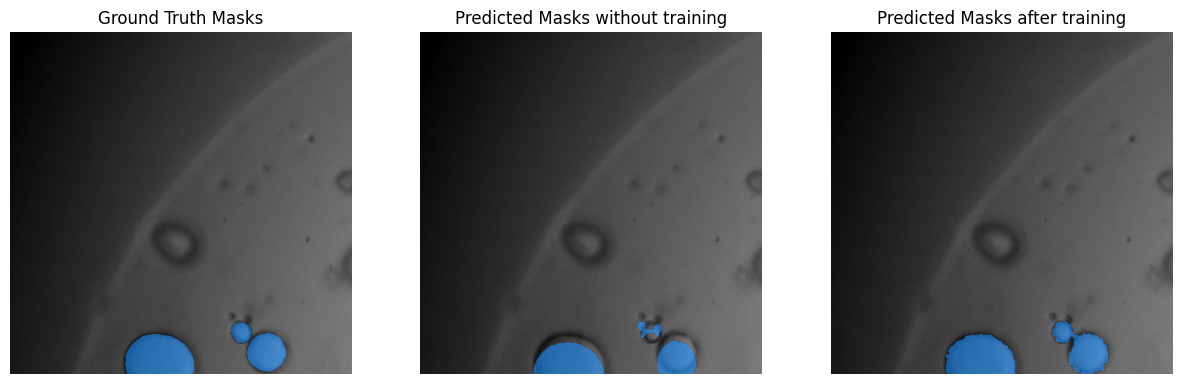

In [13]:
from utils.inference_sam import show_mask

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Ground Truth Mask
axes[0].imshow(np.array(batch["original_image"]).squeeze())
for batch in test_dataloader:
    ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
    show_mask(ground_truth_masks, axes[0])
axes[0].set_title("Ground Truth Masks")
axes[0].axis("off")

# Plot Predicted Mask before training
axes[1].imshow(np.array(batch["original_image"]).squeeze())
for mask in first_masks:
    show_mask(mask, axes[1])
axes[1].set_title("Predicted Masks without training")
axes[1].axis("off")

# Plot Predicted Mask after training
axes[2].imshow(np.array(batch["original_image"]).squeeze())
for batch in test_dataloader:
    # Compute mask
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                    input_boxes=batch["input_boxes"].to(device),
                    multimask_output=False)
    # Post-process mask
    predicted_masks = outputs.pred_masks.to(device)
    predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                    mode="bilinear", align_corners=False)
    predicted_masks = predicted_masks[..., :992, :1024]
    predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                    mode="bilinear", align_corners=False)
    # apply sigmoid
    mask_seg_prob = torch.sigmoid(predicted_masks)
    # convert soft mask to hard mask
    mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
    first_mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
    show_mask(first_mask_seg, axes[2])
axes[2].set_title("Predicted Masks after training")
axes[2].axis("off")

plt.show()